In [1]:
import logging
import tensorflow as tf


GPU_FROM = 3
GPU_TO = 4  

visible_devices = tf.config.get_visible_devices('GPU')
logging.info(f"Num GPUs visible:{len(visible_devices)}")
tf.config.set_visible_devices(visible_devices[GPU_FROM:GPU_TO],'GPU')

visible_devices = tf.config.get_visible_devices('GPU')
logging.info(f"Num GPUs to be used: {len(visible_devices)}")

2023-02-22 16:24:07.712300: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-02-22 16:24:07.865424: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-02-22 16:24:07.901983: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-02-22 16:24:08.570959: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; 

In [2]:

from segmentation.model import SpaceSegmentationTransformer
from segmentation.model import LossWithVoids

data = tf.random.stateless_binomial(shape=(10000, 100), counts=1, probs=0.8, seed=[1997,1997])+1
train_frac = int(data.shape[0]*3/4)

train_ds, val_ds = tf.data.Dataset.from_tensor_slices(data[:train_frac]), tf.data.Dataset.from_tensor_slices(data[train_frac:])

sequence_rule = "45"

def mapper(y):
    x = tf.strings.as_string(y+3)
    x = tf.strings.reduce_join(x, axis=-1)
    return tf.strings.regex_replace(x, f"({sequence_rule})", r"\1 ")

train_ds = train_ds.map(mapper)
val_ds = val_ds.map(mapper)

for f in train_ds.take(5):
    print(f)

tf.Tensor(b'5555545 5555555445 5555445 545 5555545 555545 55555445 545 545 545 555545 5545 55555445 5555445 555545 55555555545 4', shape=(), dtype=string)
tf.Tensor(b'55545 5545 5545 45 555445 5445 45 5555555555545 545 555545 545 45 55545 55555545 55555545 545 45 45 445 45 55545 55555555', shape=(), dtype=string)
tf.Tensor(b'5555544445 45 55555545 45 5555445 555555545 555555555555555555545 555445 5555555545 5555545 5545 545 5445 45 45 444', shape=(), dtype=string)
tf.Tensor(b'545 555555445 555555545 555545 555555545 5555545 5555555555555445 45 45 555545 555545 5555555555555445 555555544', shape=(), dtype=string)
tf.Tensor(b'545 5555545 45 555555555445 554445 555545 555555555545 55555545 5545 555545 5555555445 55445 5555545 4445 5445 445 5', shape=(), dtype=string)


2023-02-22 16:24:09.651097: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-02-22 16:24:10.359133: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1616] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 22296 MB memory:  -> device: 3, name: GeForce RTX 3090, pci bus id: 0000:d8:00.0, compute capability: 8.6


In [3]:
def generate_labels(text):
    max_chars = 100
    last_char = tf.strings.substr(text, max_chars, max_chars+1)
    text = tf.strings.substr(text,0, max_chars)
    text = tf.strings.lower(text)
    split_on_whitespace = tf.strings.strip(tf.strings.split(text))
    encoder_in = tf.strings.reduce_join(split_on_whitespace, axis=-1)
    
    space_indices = tf.math.cumsum(tf.strings.length(split_on_whitespace)) - 1 # subtract 1 to index from 0
    seq_len = space_indices[-1] + 1
    if not tf.strings.regex_full_match(last_char, " "):
        space_indices = space_indices[:-1]
    encoder_out = tf.ones((max_chars,))
    encoder_out = tf.concat([
        tf.ones((seq_len,)),
        tf.zeros((max_chars - seq_len,))
    ], axis=-1)
    encoder_out = tf.tensor_scatter_nd_update(
        encoder_out, 
        space_indices[...,tf.newaxis], # Expand dims to create a 'list' of indices
        tf.ones_like(space_indices, dtype=encoder_out.dtype)*2) 
    
    return encoder_in, tf.reshape(tf.cast(encoder_out-1, "float16"), (100,))

train_ds = train_ds.map(generate_labels)
val_ds = val_ds.map(generate_labels)

for f in train_ds.take(1):
    print(f)

train_ds.element_spec

(<tf.Tensor: shape=(), dtype=string, numpy=b'55555455555555445555544554555555455555455555544554554554555554555455555544555554455555'>, <tf.Tensor: shape=(100,), dtype=float16, numpy=
array([ 0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,
        1.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,
        1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  1.,  0.,
        0.,  1.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,
        0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,
        0.,  0.,  0.,  1.,  0.,  0.,  0.,  0., -1., -1., -1., -1., -1.,
       -1., -1., -1., -1., -1., -1., -1., -1., -1.], dtype=float16)>)


(TensorSpec(shape=(), dtype=tf.string, name=None),
 TensorSpec(shape=(100,), dtype=tf.float16, name=None))

In [4]:
tokenizer = tf.keras.layers.TextVectorization(
    output_sequence_length=100,
    standardize="lower_and_strip_punctuation",
    split="character",
    output_mode="int",
)

tokenizer.adapt(train_ds.take(10).map(lambda x,y: x))
tokenizer.get_vocabulary()

['', '[UNK]', '5', '4']

In [5]:
tokenizer("44444455555")

<tf.Tensor: shape=(100,), dtype=int64, numpy=
array([3, 3, 3, 3, 3, 3, 2, 2, 2, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])>

In [6]:
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Embedding
from tensorflow.keras import Sequential
from tensorflow.keras import Input
from tensorflow.keras import Model

_in = Input((1,), dtype="string") # (B,)
tokens = tokenizer(_in) # (B,100)
embeddings = Embedding(4,20)(tokens) # (B, 100, 20)
h = LSTM(6, return_sequences=True)(embeddings) # h_seq (B, 100, 6), h_final (B,6)
model = Model(_in, Dense(2, activation="softmax")(h))

In [7]:
for x in train_ds.batch(2).take(1):
    print(x)
    print(model(x[0]))

(<tf.Tensor: shape=(2,), dtype=string, numpy=
array([b'55555455555555445555544554555555455555455555544554554554555554555455555544555554455555',
       b'5554555455545455554455445455555555555545545555545545455554555555545555555455454545'],
      dtype=object)>, <tf.Tensor: shape=(2, 100), dtype=float16, numpy=
array([[ 0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,
         1.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,
         1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  1.,  0.,
         0.,  1.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,
         0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,
         0.,  0.,  0.,  1.,  0.,  0.,  0.,  0., -1., -1., -1., -1., -1.,
        -1., -1., -1., -1., -1., -1., -1., -1., -1.],
       [ 0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  1.,
         0.,  1.,  0.,  0.,  0.,  0.,  0.,  1.,  0.

2023-02-22 16:24:13.387986: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8100


tf.Tensor(
[[[0.49706763 0.50293237]
  [0.494527   0.505473  ]
  [0.49228734 0.50771266]
  [0.49029154 0.50970846]
  [0.48850685 0.51149315]
  [0.49012813 0.5098719 ]
  [0.48846194 0.5115381 ]
  [0.48693714 0.51306283]
  [0.48554298 0.514457  ]
  [0.48428032 0.5157197 ]
  [0.48314556 0.51685447]
  [0.48211613 0.5178839 ]
  [0.48118424 0.5188158 ]
  [0.48035648 0.51964355]
  [0.48283118 0.51716876]
  [0.4850514  0.5149486 ]
  [0.48399743 0.5160026 ]
  [0.48299125 0.5170088 ]
  [0.48206228 0.5179377 ]
  [0.4812122  0.5187878 ]
  [0.48042914 0.5195708 ]
  [0.48293075 0.5170693 ]
  [0.48517612 0.51482385]
  [0.4841317  0.5158683 ]
  [0.48313028 0.51686966]
  [0.48538637 0.5146136 ]
  [0.4842982  0.51570183]
  [0.4832743  0.5167257 ]
  [0.48232386 0.5176761 ]
  [0.4814392  0.51856077]
  [0.4806409  0.5193591 ]
  [0.47990206 0.520098  ]
  [0.48245412 0.5175459 ]
  [0.48156953 0.5184305 ]
  [0.48078683 0.51921314]
  [0.48005623 0.5199438 ]
  [0.4794021  0.5205979 ]
  [0.4787981  0.5212019 ]
 

2023-02-22 16:24:14.324673: I tensorflow/stream_executor/cuda/cuda_blas.cc:1614] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


In [8]:
from segmentation.metrics import SparseAccuracyWithIgnore
from segmentation.metrics import SparsePrecision
from segmentation.metrics import SparseRecall
from segmentation.metrics import SparseF1

model.compile(
    optimizer="adam",
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False, ignore_class=-1), # Why can I not ignore class 0?
    metrics=[
        # SparseAccuracyWithIgnore(ignore_token=-1),
        SparsePrecision(class_id=1, name="space_precision"),
        SparseRecall(class_id=1, name="space_recall"),
        SparseF1(class_id=1, name="space_f1"),
        SparsePrecision(class_id=0, name="char_precision"),
        SparseRecall(class_id=0, name="char_recall"),
        SparseF1(class_id=0, name="char_f1"),
    ],
)

In [9]:
train_ds = train_ds.shuffle(100).batch(8)
val_ds = val_ds.batch(8)
print(train_ds.element_spec)
model.fit(train_ds, validation_data=val_ds, epochs=10)

(TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None, 100), dtype=tf.float16, name=None))
Epoch 1/10
(None, 100, 2) (None, 100)
(None, 100, 2) (None, 100)
(None, 100, 2) (None, 100)
(None, 100, 2) (None, 100)
(None, 100, 2) (None, 100)
(None, 100, 2) (None, 100)
(None, 100, 2) (None, 100)
(None, 100, 2) (None, 100)
937/938 [============================>.] - ETA: 0s - loss: 0.2415 - space_precision: 0.9032 - space_recall: 0.5076 - space_f1: 0.6500 - char_precision: 0.7839 - char_recall: 0.9921 - char_f1: 0.8758(None, 100, 2) (None, 100)
(None, 100, 2) (None, 100)
(None, 100, 2) (None, 100)
(None, 100, 2) (None, 100)
938/938 [==============================] - 24s 22ms/step - loss: 0.2414 - space_precision: 0.9032 - space_recall: 0.5080 - space_f1: 0.6502 - char_precision: 0.7840 - char_recall: 0.9921 - char_f1: 0.8758 - val_loss: 0.0355 - val_space_precision: 0.9625 - val_space_recall: 1.0000 - val_space_f1: 0.9809 - val_char_precision: 0.8460 - val_char_recall:

In [10]:
model.evaluate(val_ds)

313/313 [==============================] - 4s 12ms/step - loss: 0.0143 - space_precision: 0.9673 - space_recall: 1.0000 - space_f1: 0.9834 - char_precision: 0.8453 - char_recall: 0.9963 - char_f1: 0.9146


[0.01428933721035719,
 0.9673189520835876,
 1.0,
 0.9833880066871643,
 0.8453080654144287,
 0.9963020086288452,
 0.9146149754524231]

In [26]:
test_inputs = tf.constant(("5554445", "55544455554445", "5454545454545454"))
preds = model(test_inputs)
truth = tf.ragged.constant([[1,1,1,1,1,1,2], [1,1,1,1,1,1,2,1,1,1,1,1,1,2], [1,1,2, 1,2, 1,2, 1,2, 1,2, 1,2, 1,2, 1]])-1
char_conditional = (truth == 0).to_tensor(False, shape=(truth.shape[0],100))
space_conditional = (truth == 1).to_tensor(False, shape=(truth.shape[0],100))

In [27]:
tf.argmax(preds, axis=-1)

<tf.Tensor: shape=(3, 100), dtype=int64, numpy=
array([[0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0

Text(0.5, 0.98, 'Probabilities of space/char conditional on character input')

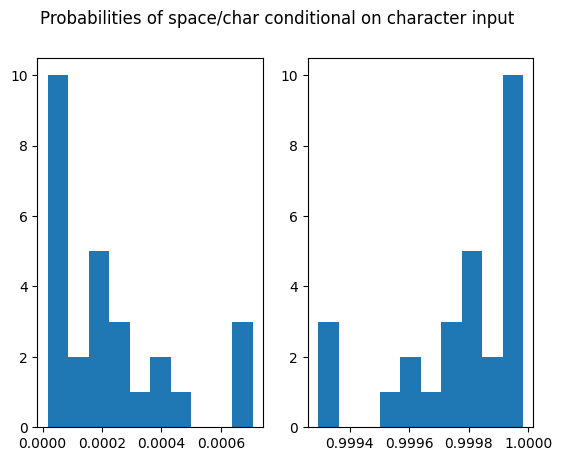

In [28]:
import matplotlib.pyplot as plt
fig, axs = plt.subplots(1,2)
prob_of_space = preds[char_conditional][...,1]
prob_of_char = preds[char_conditional][...,0]
axs[0].hist(prob_of_space)
# axs[0].set_xlim(0,1)
axs[1].hist(prob_of_char)
# axs[1].set_xlim(0,1)
fig.suptitle("Probabilities of space/char conditional on character input")

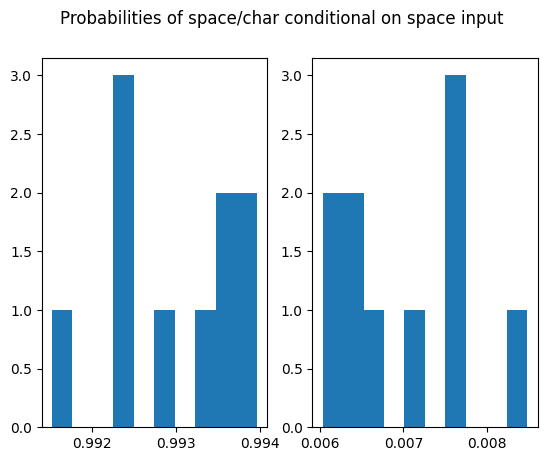

In [30]:
fig, axs = plt.subplots(1,2)
prob_of_space = preds[space_conditional][...,1]
prob_of_char = preds[space_conditional][...,0]
axs[0].hist(prob_of_space)
axs[1].hist(prob_of_char)
# axs[1].set_xlim(0,1)
fig.suptitle("Probabilities of space/char conditional on space input")

fig.show()

In [31]:
list(prob_of_char.numpy()), prob_of_space

([0.0075717354,
  0.0075717354,
  0.008480182,
  0.0076024504,
  0.007038756,
  0.006740982,
  0.006507891,
  0.0063156215,
  0.0061634253,
  0.0060348925],
 <tf.Tensor: shape=(10,), dtype=float32, numpy=
 array([0.99242824, 0.99242824, 0.99151987, 0.9923975 , 0.9929612 ,
        0.9932591 , 0.99349207, 0.99368435, 0.9938366 , 0.9939651 ],
       dtype=float32)>)